Loaded data shape: (284807, 31)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64
Fraud percentage: 0.172749%


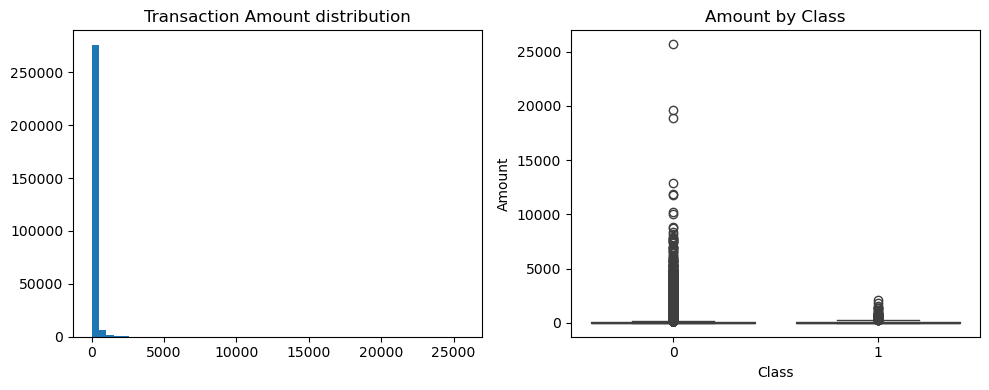

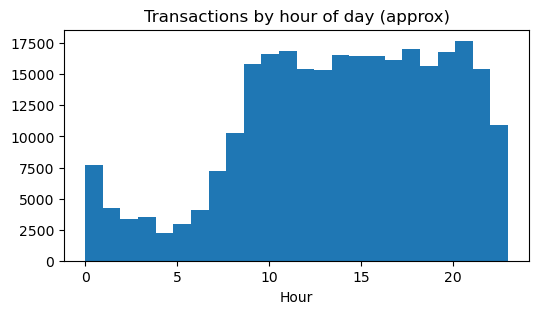

Using features count: 32
Train shape: (227845, 32) Test shape: (56962, 32)

Training baseline Logistic Regression (with class_weight=balanced)
Logistic Regression PR AUC: 0.7669682587195883

Classification report (LR) at threshold 0.3
              precision    recall  f1-score   support

           0     0.9999    0.9409    0.9695     56864
           1     0.0261    0.9184    0.0507        98

    accuracy                         0.9408     56962
   macro avg     0.5130    0.9296    0.5101     56962
weighted avg     0.9982    0.9408    0.9679     56962

Using model: XGBoost
Saved model to model_XGBoost.joblib
XGBoost PR AUC: 0.871177
XGBoost ROC AUC: 0.972431
Best F1 on test-range thresholds: 0.8631578947368421 at threshold 0.78

Classification report at best threshold
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9998     56864
           1     0.8913    0.8367    0.8632        98

    accuracy                         0.9995     56962


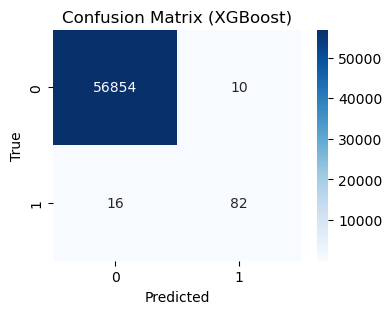

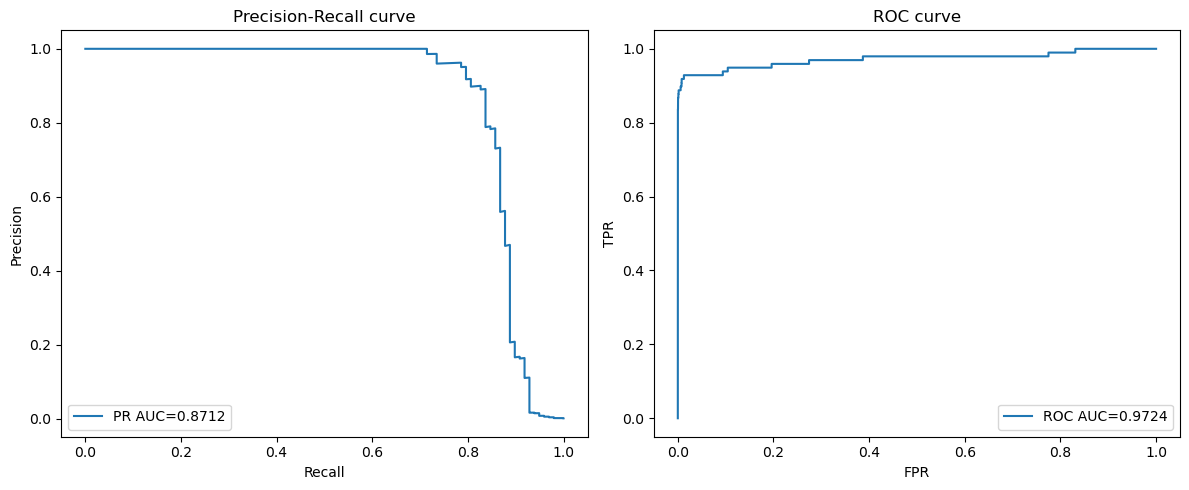


Top model feature importances:


V14       7038.098633
V4        1008.187866
V12        563.435852
V8         406.915955
V10        318.220184
Amount     296.435516
V7         285.895294
V20        261.023285
V27        248.825607
V26        236.386581
V17        234.431091
V22        230.386719
V13        227.034332
V1         223.809021
V28        212.238098
V3         210.180984
V18        188.201370
V21        171.529190
V19        167.130280
V15        161.754807
dtype: float64

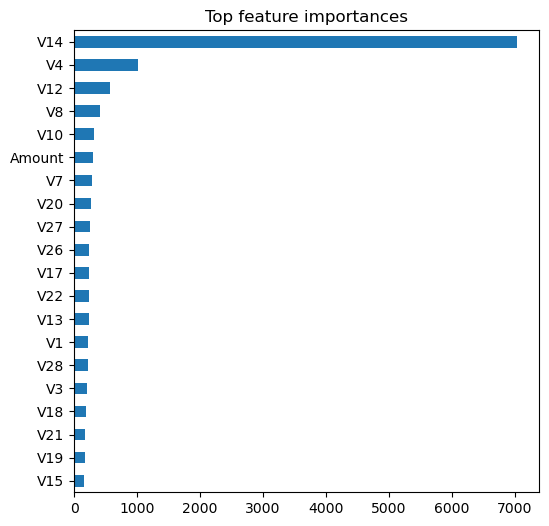

Creating SHAP explainer (this may take a moment)...
SHAP summary plot (global)


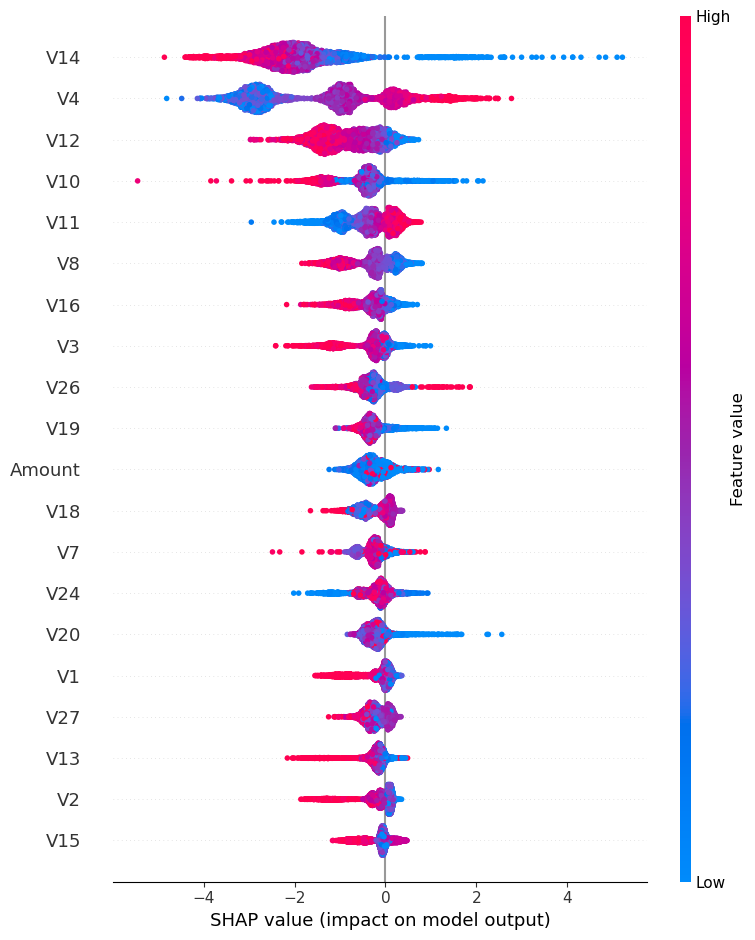

Example predicted prob: 1.7204873e-05


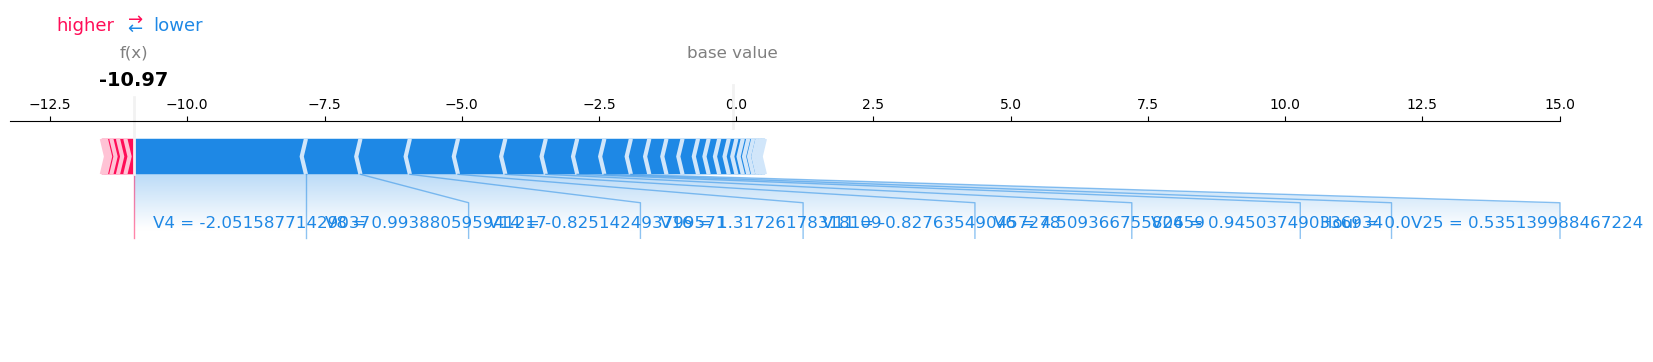

Artifacts saved to artifacts
Example single prediction -> {'probability': 8.28598058433272e-06, 'flag': 0}


In [6]:
# Fraud Detection Notebook (script-style, use in Jupyter by pasting into a .py and opening with Jupyter or using %run)
# Dataset assumed: 'creditcard.csv' in the same directory (Kaggle Credit Card Fraud Detection)
# Cells are separated with '# %%' so you can run cell-by-cell in Jupyter / VSCode.

# %%
# Install required packages (run this cell if packages are missing)
# Note: if running in an environment without pip privileges, install from terminal or use conda.
!pip install --quiet xgboost lightgbm shap matplotlib seaborn scikit-learn pandas numpy joblib

# %%
# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

import joblib

# Try to import XGBoost; fall back safely if not available
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    xgb = None
    has_xgb = False

# Try LightGBM
try:
    import lightgbm as lgb
    has_lgb = True
except Exception:
    lgb = None
    has_lgb = False

import shap

# %%
# 1) Load dataset
DATA_PATH = 'creditcard.csv'
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset {DATA_PATH} not found. Please place 'creditcard.csv' in the working directory.")

df = pd.read_csv(DATA_PATH)
print('Loaded data shape:', df.shape)

df.head()

# %%
# 2) Quick EDA
print('\nClass distribution:')
print(df['Class'].value_counts())

fraud_pct = df['Class'].mean() * 100
print(f'Fraud percentage: {fraud_pct:.6f}%')

# Amount distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['Amount'], bins=50)
plt.title('Transaction Amount distribution')

plt.subplot(1,2,2)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Amount by Class')
plt.tight_layout()
plt.show()

# Time distribution - convert Time to hours
plt.figure(figsize=(6,3))
plt.hist((df['Time'] // 3600) % 24, bins=24)
plt.title('Transactions by hour of day (approx)')
plt.xlabel('Hour')
plt.show()

# %%
# 3) Feature engineering
# The Kaggle dataset already has PCA components (V1..V28), plus 'Time' and 'Amount'.
# We'll create a few simple engineered features: Hour, AmountLog, and scaled Amount.

df['Hour'] = (df['Time'] // 3600) % 24
# Log transform amount (add small constant)
df['Amount_log1p'] = np.log1p(df['Amount'])

# rolling features per 'customer' are not possible since dataset anonymized; we simulate simple stats
# For demonstration we create 'Amount_zscore' across dataset (not ideal for per-user). 
from scipy import stats

df['Amount_zscore'] = stats.zscore(df['Amount'].replace(0, np.nan).fillna(0))

# %%
# 4) Prepare X, y and train-test split
FEATURES = [c for c in df.columns if c not in ['Class', 'Time']]
print('Using features count:', len(FEATURES))

X = df[FEATURES].copy()
y = df['Class'].copy()

# Scale Amount-like engineered features
scaler = StandardScaler()
X[['Amount', 'Amount_log1p', 'Amount_zscore']] = scaler.fit_transform(X[['Amount','Amount_log1p','Amount_zscore']])

# Stratified split preserving class ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# %%
# 5) Baseline model: Logistic Regression or RandomForest (fast)
from sklearn.linear_model import LogisticRegression

print('\nTraining baseline Logistic Regression (with class_weight=balanced)')
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
clf_lr.fit(X_train, y_train)

# Evaluate
proba_lr = clf_lr.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, proba_lr)
pr_auc_lr = auc(recall, precision)
print('Logistic Regression PR AUC:', pr_auc_lr)

# Print classification report at threshold tuned for recall (example threshold 0.3)
thr = 0.3
pred_lr = (proba_lr >= thr).astype(int)
print('\nClassification report (LR) at threshold', thr)
print(classification_report(y_test, pred_lr, digits=4))

# %%
# 6) Stronger model: XGBoost / LightGBM / RandomForest
# We'll try XGBoost if available, else LightGBM, else RandomForest.

model = None
model_name = None
scale_pos_weight = (y_train==0).sum() / (y_train==1).sum()

if has_xgb:
    model_name = 'XGBoost'
    model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42
    )
elif has_lgb:
    model_name = 'LightGBM'
    model = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        class_weight='balanced',
        random_state=42
    )
else:
    model_name = 'RandomForest'
    model = RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )

print(f'Using model: {model_name}')
model.fit(X_train, y_train)

# Save the model
joblib.dump(model, f'model_{model_name}.joblib')
print('Saved model to', f'model_{model_name}.joblib')

# %%
# 7) Evaluation
proba = model.predict_proba(X_test)[:,1]

# PR AUC
precision, recall, _ = precision_recall_curve(y_test, proba)
pr_auc = auc(recall, precision)
print(f'{model_name} PR AUC: {pr_auc:.6f}')

# ROC AUC
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
print(f'{model_name} ROC AUC: {roc_auc:.6f}')

# Choose a threshold — here we pick threshold by maximizing F1 on validation (quick heuristic)
from sklearn.metrics import f1_score

thresholds = np.linspace(0.01,0.9,90)
best_thr = 0.5
best_f1 = 0
for t in thresholds:
    preds = (proba >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = t

print('Best F1 on test-range thresholds:', best_f1, 'at threshold', best_thr)

preds_best = (proba >= best_thr).astype(int)
print('\nClassification report at best threshold')
print(classification_report(y_test, preds_best, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, preds_best)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix ({model_name})')
plt.show()

# Plot PR and ROC curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(recall, precision, label=f'PR AUC={pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.4f}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend()
plt.tight_layout()
plt.show()

# %%
# 8) Feature importance (global)
print('\nTop model feature importances:')
try:
    if model_name == 'XGBoost':
        imp = model.get_booster().get_score(importance_type='gain')
        imp = pd.Series(imp).sort_values(ascending=False).head(20)
    elif model_name == 'LightGBM':
        imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
    else:
        imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

    display(imp)
    plt.figure(figsize=(6,6))
    imp.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title('Top feature importances')
    plt.show()
except Exception as e:
    print('Could not compute feature importances:', e)

# %%
# 9) SHAP explanations for selected predictions
# SHAP can be slow — run on a sample
sample_size = 5000
X_shap = X_test.sample(min(sample_size, X_test.shape[0]), random_state=42)
y_shap = y_test.loc[X_shap.index]

print('Creating SHAP explainer (this may take a moment)...')
if model_name == 'XGBoost' and has_xgb:
    explainer = shap.TreeExplainer(model)
elif model_name == 'LightGBM' and has_lgb:
    explainer = shap.TreeExplainer(model)
else:
    # For RandomForest or non-tree models, use KernelExplainer (much slower); instead use TreeExplainer if possible
    try:
        explainer = shap.TreeExplainer(model)
    except Exception:
        explainer = None

if explainer is not None:
    shap_values = explainer.shap_values(X_shap)
    # For binary classification shap_values can be a list [neg, pos]
    if isinstance(shap_values, list):
        shap_vals = shap_values[1]
    else:
        shap_vals = shap_values

    print('SHAP summary plot (global)')
    shap.summary_plot(shap_vals, X_shap, show=True)

    # force plot for a single example
    idx = X_shap.index[0]
    print('Example predicted prob:', model.predict_proba(X_shap.loc[[idx]])[0,1])
    shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value, shap_vals[0,:], X_shap.iloc[0,:], matplotlib=True, show=True)
else:
    print('SHAP explainer could not be created for this model in this environment.')

# %%
# 10) Save artifacts and generate a small inference function
import json
ARTIFACTS_DIR = 'artifacts'
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

joblib.dump(scaler, os.path.join(ARTIFACTS_DIR, 'scaler.joblib'))
joblib.dump(X_train.columns.tolist(), os.path.join(ARTIFACTS_DIR, 'feature_list.joblib'))

print('Artifacts saved to', ARTIFACTS_DIR)

# Inference helper
def predict_transaction(df_row):
    """df_row: DataFrame single row with same columns as original X (can be raw with 'Amount' and 'Time').
    Returns predicted probability of fraud and binary flag at chosen threshold.
    """
    # Create a copy and ensure all required features exist
    r = df_row.copy()
    # Feature engineering as above
    if 'Hour' not in r:
        r['Hour'] = (r['Time'] // 3600) % 24
    r['Amount_log1p'] = np.log1p(r['Amount'])
    r['Amount_zscore'] = (r['Amount'] - df['Amount'].mean()) / (df['Amount'].std() + 1e-9)

    # Keep only required features
    features = joblib.load(os.path.join(ARTIFACTS_DIR, 'feature_list.joblib'))
    r = r[features]
    # Scale amount columns using saved scaler
    r[['Amount','Amount_log1p','Amount_zscore']] = scaler.transform(r[['Amount','Amount_log1p','Amount_zscore']])

    proba = model.predict_proba(r)[:,1][0]
    flag = int(proba >= best_thr)
    return {'probability': float(proba), 'flag': flag}

# Example usage (take one transaction from test)
example = df.loc[[X_test.index[0]]]
print('Example single prediction ->', predict_transaction(example))

# %%
# 11) Next steps & tips (do not run)
# - Improve feature engineering: build per-customer aggregates (count in last 1h/24h, avg amount per customer, etc.) if you have customer IDs
# - Use time-based CV or rolling window validation
# - Build a calibrated probability (Platt scaling or isotonic) if you need calibrated probabilities
# - Add business rules on top of ML to reduce false positives
# - Deploy with FastAPI + Docker for a mini demo

# End of notebook
